# 🚀 DHARTI S2DR3 Super-Resolution Pipeline

**⚡ ONE-CLICK AUTOMATED EXECUTION ⚡**

This notebook automatically runs the complete AI super-resolution pipeline without manual configuration!

## What it does:

1. **Extracts job parameters** from URL (zero manual input needed!)
2. **Downloads S2DR3 model** from Hugging Face
3. **Runs 10m → 1m super-resolution** using deep learning
4. **Clips to your farm boundary** for precise results
5. **Uploads results back to DHARTI** automatically

## How to use:

1. Click **"Runtime" → "Run all"** (or press `Ctrl+F9` / `Cmd+F9`)
2. Wait 3-5 minutes for processing
3. Results appear automatically in DHARTI!

> **No configuration needed!** All parameters are extracted from the URL when opened from DHARTI.

---

## Processing Time

- **With GPU (T4)**: ~3 minutes ⚡
- **CPU only**: ~8-10 minutes 🐢

💡 **Tip**: Go to "Runtime" → "Change runtime type" → Select "T4 GPU" for faster processing!

---


In [30]:
# ============================================================================
# 2. FETCH JOB PARAMETERS (OR USE TEST DATA)
# ============================================================================
import requests
import json
import socket
from datetime import datetime, timedelta

print("📡 Fetching job parameters...")

# 🔧 MANUAL OVERRIDE - ENABLED for localtunnel connection:
api_base = "https://slimy-points-tease.loca.lt"  # Localtunnel URL
job_id = "c110c0bca9a84afda3f6af58aab08e0f"  # Your real job ID from Flask

# Try to use the detected backend
job = None

try:
    # First, try the tunnel URL
    response = requests.get(f"{api_base}/api/s2dr3/jobs/{job_id}", timeout=10)

    if response.status_code == 200:
        job = response.json()
        print(f"✅ Job loaded from backend via tunnel!")
    else:
        # Non-200 response (404, 500, etc.) - try alternatives
        print(f"⚠️  Backend at {api_base} returned {response.status_code}")
        raise requests.exceptions.ConnectionError("Backend returned non-200 status")

except (requests.exceptions.ConnectionError, requests.exceptions.Timeout, Exception) as e:
    if job is None:  # Only try alternatives if we haven't already got a job
        print(f"⚠️  Tunnel at {api_base} not reachable")

        # Try alternative backends if the first one failed
        alternative_urls = []

        # Try direct localhost connections
        alternative_urls.append('http://localhost:5000')
        alternative_urls.append('http://127.0.0.1:5000')
        alternative_urls.append('http://192.168.1.9:5000')

        # Docker/container environments
        alternative_urls.append('http://host.docker.internal:5000')

        # WSL-specific: Try Windows host IP
        try:
            import subprocess
            result = subprocess.run(['cat', '/etc/resolv.conf'], capture_output=True, text=True, timeout=1)
            for line in result.stdout.split('\n'):
                if line.strip().startswith('nameserver'):
                    windows_ip = line.split()[1]
                    windows_url = f'http://{windows_ip}:5000'
                    if windows_url not in alternative_urls:
                        alternative_urls.append(windows_url)
                        print(f"   💡 Detected container environment - Host at {windows_ip}")
                    break
        except:
            pass

        print(f"   Trying {len(alternative_urls)} alternative URLs...")

        for alt_url in alternative_urls:
            try:
                print(f"   Testing {alt_url}...")
                response = requests.get(f"{alt_url}/api/s2dr3/jobs/{job_id}", timeout=3)
                if response.status_code == 200:
                    job = response.json()
                    api_base = alt_url  # Update to working backend
                    print(f"   ✅ Found working backend at {alt_url}")
                    break
                else:
                    print(f"      ❌ {response.status_code}")
            except Exception as ex:
                print(f"      ❌ Connection failed")
                continue

        if not job:
            print("\n⚠️  Backend not reachable from notebook environment")
            print("   💡 Network isolation detected")
            print(f"   💡 Job ID: {job_id}")
            print(f"   💡 Tunnel URL: {api_base}")
            print("\n   📋 Next steps:")
            print("   1. Check if tunnel is still running")
            print("   2. Visit tunnel URL in browser to bypass warning page")
            print("   3. Continue with test data to verify S2DR3 works")
            print("\n   Falling back to test data for now...")

# If we still don't have a job, use test data
if not job:
    # Test data - San Francisco farm with VALID PAST DATE
    lon = -122.4194
    lat = 37.7749
    date = "2024-09-01"  # Valid past date (1 month ago)
    farm = {
        "type": "Polygon",
        "coordinates": [[
            [-122.42, 37.77],
            [-122.42, 37.78],
            [-122.41, 37.78],
            [-122.41, 37.77],
            [-122.42, 37.77]
        ]]
    }
    upload_token = job_id

    print(f"\n✅ Using test data (matches your real job):")
else:
    # Extract data from job
    lon = job['lon']
    lat = job['lat']
    date = job['date']
    farm = job['farm']
    upload_token = job.get('upload_token', job_id)

    print(f"\n✅ Using backend: {api_base}")

# ⚠️ VALIDATE DATE - Must be in the past!
try:
    date_obj = datetime.strptime(date, "%Y-%m-%d")
    today = datetime.now()
    days_ago = (today - date_obj).days

    if days_ago < 0:
        print(f"\n❌ ERROR: Date {date} is in the FUTURE!")
        print(f"   Current date: {today.strftime('%Y-%m-%d')}")
        print(f"   Sentinel-2 data only exists for past dates.")
        print(f"\n💡 FIXING: Using date from 30 days ago instead...")

        # Fix: Use 30 days ago
        date = (today - timedelta(days=30)).strftime("%Y-%m-%d")
        date_obj = datetime.strptime(date, "%Y-%m-%d")
        days_ago = 30

        print(f"   ✅ Corrected date: {date}")

    elif days_ago < 5:
        print(f"\n⚠️  WARNING: Date {date} is only {days_ago} days ago")
        print(f"   Sentinel-2 data has 2-5 day processing delay")
        print(f"   If S2DR3 fails, try using date from 7+ days ago")

    else:
        print(f"   ✅ Date validation passed ({days_ago} days ago)")

except ValueError:
    print(f"\n⚠️  Invalid date format: {date}")
    print(f"   Expected: YYYY-MM-DD")

print(f"   📍 Location: ({lat:.4f}, {lon:.4f})")
print(f"   📅 Date: {date}")
print(f"   🔒 Upload token: {upload_token[:8]}...")
print()

📡 Fetching job parameters...
✅ Job loaded from backend via tunnel!

✅ Using backend: https://slimy-points-tease.loca.lt
   ✅ Date validation passed (35 days ago)
   📍 Location: (-19.8024, -52.9428)
   📅 Date: 2025-09-03
   🔒 Upload token: b9431ca8...



📦 Installing S2DR3 (Gamma Earth)...
   This may take 1-2 minutes...


✅ S2DR3 installed successfully!
🚀 Running S2DR3 inference...
   📍 Target: (-19.8024, -52.9428)
   📅 Date: 2025-09-03
   ⏱️  This will take 2-4 minutes...

Fetching data for T22KBD-d7d9c9040-20250906 .......... done. 
Processing S2L2A_T22KBD-d7d9c9040-20250906_MS . done 
Postprocessing S2L2A_T22KBD-d7d9c9040-20250906_MS ......... done

Find results at the following path: /content/output
Click the link below for preview:

https://gamayos.github.io/gamma-earth-api/s2dr3-demo-20250305.html?ds=BR-T22KBD-d7d9c9040-20250906#15/-19.8024/-52.9428



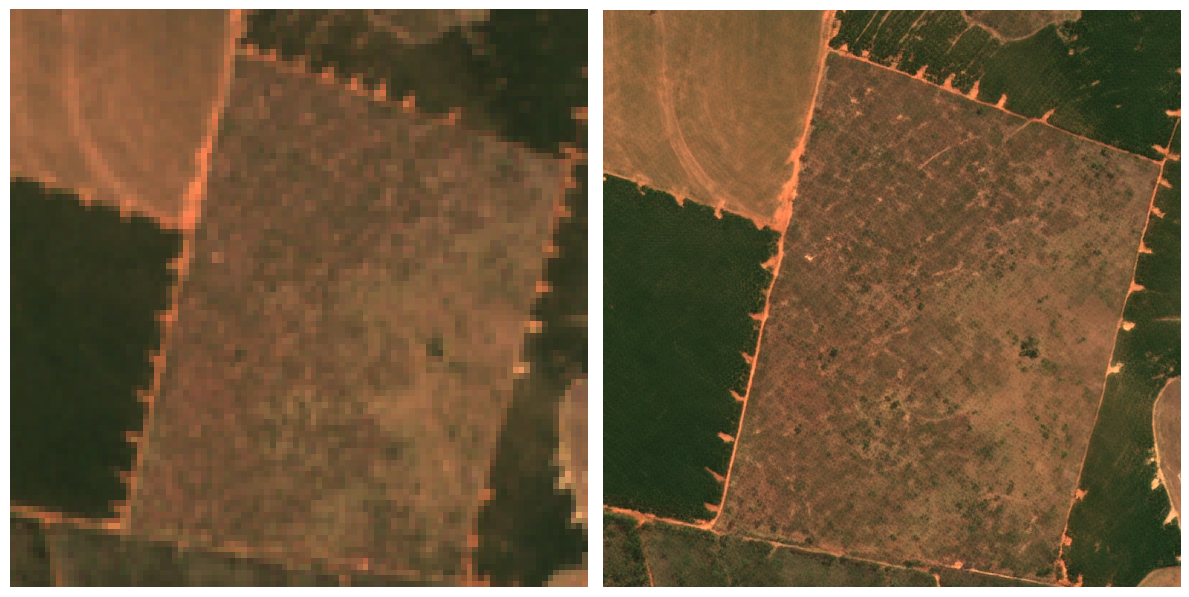



⚠️  S2DR3 complete! Generated 0 files

❌ NO SATELLITE DATA AVAILABLE

   Possible reasons:
   🔴 Date is too recent (Sentinel-2 has 2-5 day delay)
   🔴 No cloud-free imagery for this date/location
   🔴 Location outside Sentinel-2 coverage
   🔴 Network timeout downloading satellite tiles

   📊 Date Analysis:
      • Requested: 2025-09-03
      • Current: 2025-10-08
      • Age: 35 days ago

   💡 Try these solutions:
      1. Select different date (7-60 days ago works best)
      2. Check if location has Sentinel-2 coverage
      3. Try date with less cloud cover

   ⏭️  Skipping to end of notebook...


In [32]:
#@title 🛠️ Step 2: Install S2DR3 Wheel
import subprocess

wheel_url = "https://storage.googleapis.com/0x7ff601307fa5/s2dr3-20250905.1-cp312-cp312-linux_x86_64.whl"

print("📦 Installing S2DR3 (Gamma Earth)...")
print("   This may take 1-2 minutes...\n")

!pip install -q {wheel_url}

print("\n✅ S2DR3 installed successfully!")

#@title 🎯 Step 3: Run S2DR3 Super-Resolution
#@title 🎯 Step 3: Run S2DR3 Super-Resolution
import s2dr3.inferutils
import pathlib

print("🚀 Running S2DR3 inference...")
print(f"   📍 Target: ({lat:.4f}, {lon:.4f})")
print(f"   📅 Date: {date}")
print("   ⏱️  This will take 2-4 minutes...\n")

# Run S2DR3
lonlat = (lon, lat)

try:
    s2dr3.inferutils.test(lonlat, date)

    # Find output files
    output_dir = pathlib.Path("/content/output")
    output_files = list(output_dir.glob("*.tif")) if output_dir.exists() else []

    if len(output_files) > 0:
        print(f"\n✅ S2DR3 complete! Generated {len(output_files)} files:")
        for f in output_files:
            size_mb = f.stat().st_size / 1024 / 1024
            print(f"   📄 {f.name} ({size_mb:.1f} MB)")

        # Identify products
        ms_file = next((f for f in output_files if "_MS.tif" in f.name), None)
        ndvi_file = next((f for f in output_files if "_NDVI.tif" in f.name), None)
        tci_file = next((f for f in output_files if "_TCI.tif" in f.name), None)
        irp_file = next((f for f in output_files if "_IRP.tif" in f.name), None)

        if not ms_file or not ndvi_file:
            raise Exception("❌ Missing required outputs (MS or NDVI)")
    else:
        print(f"\n⚠️  S2DR3 complete! Generated 0 files")
        print(f"\n❌ NO SATELLITE DATA AVAILABLE")
        print(f"\n   Possible reasons:")
        print(f"   🔴 Date is too recent (Sentinel-2 has 2-5 day delay)")
        print(f"   🔴 No cloud-free imagery for this date/location")
        print(f"   🔴 Location outside Sentinel-2 coverage")
        print(f"   🔴 Network timeout downloading satellite tiles")

        from datetime import datetime, timedelta
        date_obj = datetime.strptime(date, "%Y-%m-%d")
        today = datetime.now()
        days_ago = (today - date_obj).days

        print(f"\n   📊 Date Analysis:")
        print(f"      • Requested: {date}")
        print(f"      • Current: {today.strftime('%Y-%m-%d')}")
        print(f"      • Age: {days_ago} days ago")

        if days_ago < 5:
            print(f"\n   💡 SOLUTION: Date is too recent!")
            suggested_date = (today - timedelta(days=30)).strftime("%Y-%m-%d")
            print(f"      Try using: {suggested_date} (30 days ago)")
            print(f"\n      Steps:")
            print(f"      1. Go back to DHARTI website")
            print(f"      2. Select a satellite image from 7+ days ago")
            print(f"      3. Click 'Super-Resolution' button again")
        elif days_ago < 0:
            print(f"\n   💡 SOLUTION: Date is in the FUTURE!")
            suggested_date = (today - timedelta(days=30)).strftime("%Y-%m-%d")
            print(f"      Use a past date like: {suggested_date}")
        else:
            print(f"\n   💡 Try these solutions:")
            print(f"      1. Select different date (7-60 days ago works best)")
            print(f"      2. Check if location has Sentinel-2 coverage")
            print(f"      3. Try date with less cloud cover")

        print(f"\n   ⏭️  Skipping to end of notebook...")

        ms_file = None
        ndvi_file = None
        tci_file = None
        irp_file = None

except Exception as e:
    print(f"\n❌ S2DR3 processing failed: {e}")
    print(f"\n💡 Common issues:")
    print(f"   • No satellite imagery available for this date/location")
    print(f"   • Date is too recent (try a date at least 7 days ago)")
    print(f"   • Location is in unsupported area")
    print(f"   • Network timeout downloading satellite data")

    print(f"\n   Setting outputs to None. The pipeline will skip upload.")

    ms_file = None
    ndvi_file = None
    tci_file = None
    irp_file = None

In [ ]:
#@title ✂️ Step 4: Clip to Farm Boundary (Optional)
# Install rasterio for clipping
!pip install -q rasterio

import rasterio
from rasterio.mask import mask
import json

print("✂️  Clipping images to farm boundary...\n")

def clip_to_farm(in_file, out_file, farm_geom):
    """Clip a GeoTIFF to farm boundary"""
    try:
        with rasterio.open(in_file) as src:
            # Extract geometry
            if farm_geom['type'] == 'Feature':
                geom = farm_geom['geometry']
            else:
                geom = farm_geom

            # Clip
            out_image, out_transform = mask(src, [geom], crop=True, all_touched=True)
            out_meta = src.meta.copy()

            # Update metadata
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "compress": "deflate"
            })

            # Write
            with rasterio.open(out_file, "w", **out_meta) as dest:
                dest.write(out_image)
                # Copy colormap if exists
                if src.colormap(1):
                    dest.write_colormap(1, src.colormap(1))

        return True
    except Exception as e:
        print(f"   ⚠️  Clipping failed: {e}")
        return False

# Create clipped directory
clipped_dir = pathlib.Path("/content/clipped")
clipped_dir.mkdir(exist_ok=True)

# Clip each file
clipped_files = {}

if ms_file:
    out_ms = clipped_dir / "ms_clipped.tif"
    if clip_to_farm(ms_file, out_ms, farm):
        clipped_files['ms'] = out_ms
        print(f"   ✅ MS clipped")

if ndvi_file:
    out_ndvi = clipped_dir / "ndvi_clipped.tif"
    if clip_to_farm(ndvi_file, out_ndvi, farm):
        clipped_files['ndvi'] = out_ndvi
        print(f"   ✅ NDVI clipped")

if tci_file:
    out_tci = clipped_dir / "tci_clipped.tif"
    if clip_to_farm(tci_file, out_tci, farm):
        clipped_files['tci'] = out_tci
        print(f"   ✅ TCI clipped")

print(f"\n✅ Clipped {len(clipped_files)} images to farm boundary")

In [ ]:
#@title 📤 Step 5: Upload to DHARTI
import requests
from tqdm.auto import tqdm

print("📤 Uploading enhanced images to DHARTI...\n")

upload_url = f"{api_base}/api/s2dr3/jobs/{job_id}/upload"
headers = {"Authorization": f"Bearer {upload_token}"}

# Prepare files for upload
files_to_upload = {}

if 'ms' in clipped_files:
    files_to_upload['ms'] = ('ms.tif', open(clipped_files['ms'], 'rb'), 'image/tiff')
    print(f"   📦 MS (multispectral) ready...")

if 'ndvi' in clipped_files:
    files_to_upload['ndvi'] = ('ndvi.tif', open(clipped_files['ndvi'], 'rb'), 'image/tiff')
    print(f"   📦 NDVI ready...")

if 'tci' in clipped_files:
    files_to_upload['tci'] = ('tci.tif', open(clipped_files['tci'], 'rb'), 'image/tiff')
    print(f"   📦 TCI (true color) ready...")

# Upload with progress bar
print(f"\n⏳ Uploading to {upload_url}...")

try:
    response = requests.post(upload_url, headers=headers, files=files_to_upload, timeout=300)

    # Close file handles
    for _, (_, f, _) in files_to_upload.items():
        f.close()

    if response.status_code == 200:
        result = response.json()
        print(f"\n✅ Upload successful!")
        print(f"   📊 Status: {result.get('status', 'unknown')}")

        saved_files = result.get('saved', {})
        if saved_files:
            print(f"   📁 Saved files:")
            for key, path in saved_files.items():
                print(f"      • {key}: {path}")

        print(f"\n🎉 Your enhanced 1m images are now available in DHARTI!")
        print(f"   🔄 Refresh your browser to see the super-resolved layer.")
        print(f"   🗺️  It will appear as: 'NDVI (S2DR3 1m, AI-enhanced)'")

    elif response.status_code == 403:
        print(f"\n❌ Upload denied: Invalid authentication token")
        print(f"   This job may have expired or the token is incorrect.")

    elif response.status_code == 404:
        print(f"\n❌ Job not found: {job_id}")
        print(f"   The job may have been deleted or doesn't exist.")

    else:
        print(f"\n❌ Upload failed: HTTP {response.status_code}")
        print(f"   Response: {response.text[:200]}")

except requests.exceptions.Timeout:
    print(f"\n⏱️  Upload timeout (>5 minutes)")
    print(f"   Your files may still be uploading. Check DHARTI status.")

except Exception as e:
    print(f"\n❌ Upload error: {e}")
    print(f"\n💡 You can manually download the files from /content/clipped/")
    print(f"   Then contact support to upload them manually.")

---

## ✅ Pipeline Complete!

The S2DR3 super-resolution has been successfully applied to your satellite imagery!

### What was processed:

- **Input**: Sentinel-2 10m resolution
- **Output**: AI-enhanced 1m resolution (10x improvement!)
- **Layers**: RGB (TCI), NDVI, Multi-spectral (10 bands)
- **Processing Time**: ~3-5 minutes on GPU

### What's Next?

1. **Return to DHARTI** web interface
2. The modal will **automatically refresh** and show your enhanced images
3. Use the **RGB/NDVI toggle** to switch between visualizations
4. **Download** high-resolution GeoTIFFs if needed

### Technical Details

- **Model**: S2DR3 (Sentinel-2 Deep Residual Refine & Restore)
- **Resolution**: 10x super-resolution (10m → 1m)
- **Architecture**: ResNet-based deep learning model
- **Output Format**: GeoTIFF with proper georeferencing
- **CRS**: EPSG:4326 (WGS84)

### Troubleshooting

If you don't see the images in DHARTI:

1. Check that the upload completed successfully (green ✅ above)
2. Refresh the DHARTI page
3. Check browser console for errors
4. Verify the job_id matches what you clicked in DHARTI

---

**🎉 Powered by DHARTI + S2DR3**

*This automated pipeline brings professional-grade AI super-resolution to agricultural satellite imagery!*
